# Optimization with uncertain 𝛼 functions and number of items sold

This notebook aims to show the obtained results of developing a learner which works with aggregated data, unknown 𝛼 functions and unknown number of units sold per product. The learner will have to estimate the 𝛼 functions while trying to make the best predictions in order to minimize regret. 

As the provious one, this learner employs a Multi Armed Bandit algorithm at its core, implemented via a Gaussian Process, in order to exploit continuity between the different arms. The learner will have 5 different Gaussian Processes, one for each subcampaign, since it has to estimate a unique 𝛼 function for each one of them.
As specified in the assignment, we implemented two different variations of the learner. One will combine Gaussian Processes with Thompson Sampling, the other will combine Gaussian Processes with UCB1.

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n 
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('seaborn-v0_8-dark')

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
def compute_regret(rewards, avg_clairvoyant_reward):
    regret = avg_clairvoyant_reward - rewards
    regret[regret<0] = 0
    return np.cumsum(regret)


In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiment(n_days, rewards, avg_clairvoyant_reward, title, reward_color='cornflowerblue', regret_color='salmon'):

    regret_plot = compute_regret(rewards, avg_clairvoyant_reward)
    clairvoyant_plot = np.ones(len(rewards)) * avg_clairvoyant_reward

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(rewards, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} reward')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[1].plot(regret_plot, color=regret_color)
    ax[1].title.set_text(f'{title} regret')
        
    plt.show()

### Environment setup
We will run both learners in the same exact environment.

In [4]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.2, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.5, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 80),
                UserClassParameters(20, 0.05, 360),
            ],
            [
                UserClassParameters(33, 0.4, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 300),
                UserClassParameters(36, 0.05, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=400,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[3, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.7, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.05, 0, 0, 0.25, 0],
            ]
        ),
    )
    return env

In [5]:
# Random Number Generator used as a source of randomness by the environment and the simulation
seed =  1337
rng = np.random.default_rng(seed)

In [6]:
# Creating the environment
env = make_env(rng)

#### Default parameters

In [7]:
# Simulation separated default parameters
sim_n_days = 50
avg_clairvoyant_reward = clairvoyant_reward(env, 1000, 400, 20) - 100

## GP Thompson Sampling implementation

In [8]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.TWO,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

In [9]:
# Running the simulation
simulation.simulate(sim_n_days)
ts_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

### Results

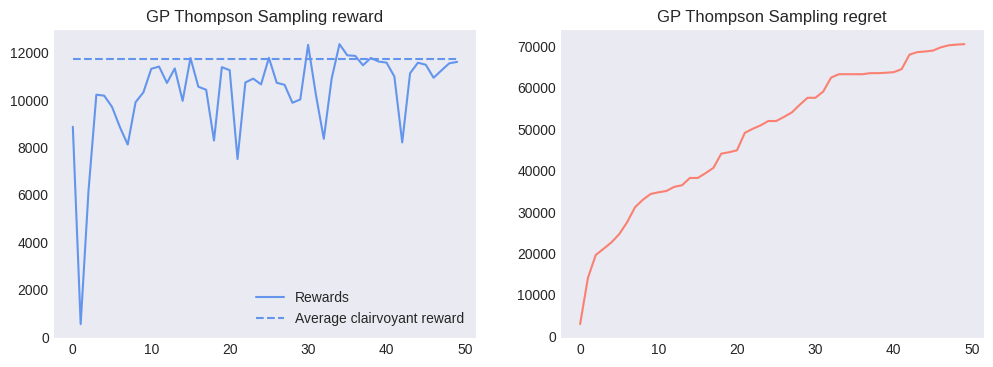

In [10]:
# Plotting the experiment
plot_experiment(sim_n_days, ts_rewards, avg_clairvoyant_reward, 'GP Thompson Sampling')

The Thompson Sampling is still able to converge to an optimal solution, however we can observe much more instability compared to the previous step. This is probably caused by the fact that the algorithm is much more "blind", knowing less information about the environment. This leads to a more uncertain estimation, hence the instability.

## GP UCB1 implementation

In [11]:
rng = np.random.default_rng(seed)
env = make_env(rng)

In [12]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.TWO,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPUCB1,
)

In [13]:
# Running the simulation
simulation.simulate(sim_n_days)
ucb1_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

### Results

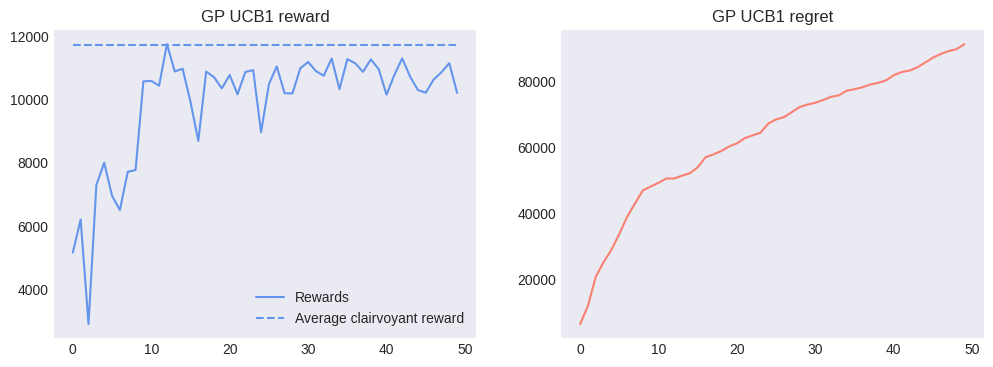

In [14]:
# Plotting the experiment
plot_experiment(sim_n_days, ucb1_rewards, avg_clairvoyant_reward, 'GP UCB1')

As we can see, with this many uknown information UCB1 is not able to converge to an optimal solution. The difference compared to TS can be explained by the fact that thanks to its randomness TS is able to try a lot of arms without much discrimination, while UCB1 will deterministically settle on a solution. In this case TS comes really in handy by counteracting the little amount of information.

Important note: GP-UCB1 in this configuration is able to converge to the optimal solution depending on the seed, but the plotted behaviour is very common. We kept this as the main example because we think that it captures differences really well. 

## Comparing GP-TS with GP-UCB1

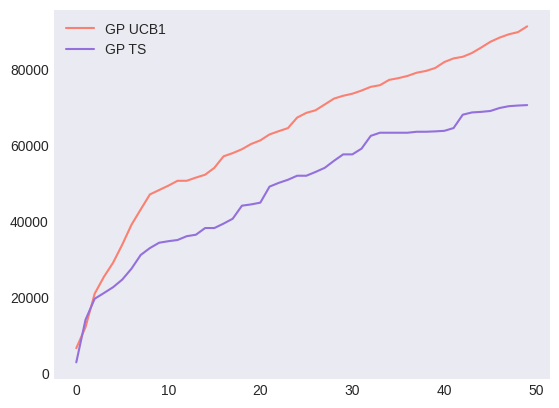

In [15]:
ucb1_regret = compute_regret(ucb1_rewards, avg_clairvoyant_reward)
ts_regret = compute_regret(ts_rewards, avg_clairvoyant_reward)

plt.plot(ucb1_regret, color='salmon', label='GP UCB1')
plt.plot(ts_regret, color='mediumpurple', label='GP TS')
plt.legend()

UCB1 is clearly the worst performer between the two. The difference might not seem big, but on a longer simulation the difference will become greater and greater since the TS has achieved an optimal solution, therefore the regret will almost not increase, while the UCB1's regret increases linearly. 

## Comparison with previous step

In [16]:
prev_seed = 1501
rng = np.random.default_rng(prev_seed)
env = make_env(rng)

# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.ONE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

# Running the simulation
simulation.simulate(sim_n_days)
prev_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

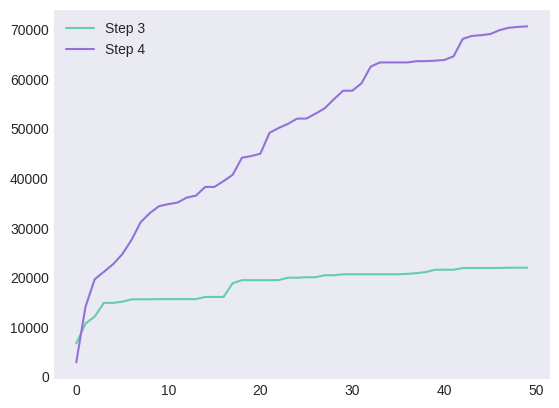

In [17]:
prev_regret = compute_regret(prev_rewards, avg_clairvoyant_reward)

plt.plot(prev_regret, color='mediumaquamarine', label='Step 3')
plt.plot(ts_regret, color='mediumpurple', label='Step 4')
plt.legend()